# Example of high-level interface

In [1]:
import numpy as np
import pylab as plt
import swyft
import torch
from scipy import stats
from tqdm import tqdm
from itertools import compress
from tqdm import tqdm
%load_ext autoreload
%autoreload 2

np.random.seed(25)
torch.manual_seed(25)

In [2]:
DEVICE = 'cuda:0'
MAX_EPOCHS = 100
NSAMPLES = 20000

## Toy generative model

In [3]:
def simulator(z):
    out = []
    for i in range(0, len(z), 2):
        r = ((z[i]-0.5)**2 + (z[i+1]-0.5)**2)**0.5
        mu = 1/(10*(r-0.2)**2+1e-2)
        out += [mu]
    x = np.random.poisson(out)
    return x

In [4]:
def noise(x, z):
    n = np.random.poisson(10., x.shape)
    return n + x

In [5]:
z0 = np.array([0.5, 0.7]*2)
zdim = len(z0)
x0 = noise(simulator(z0), z0)
comb1d = [[i] for i in range(zdim)]
comb2d = swyft.comb2d(range(zdim))
print(x0, z0)

[122 105] [0.5 0.7 0.5 0.7]


## Automatic inference 1-dim and 2-dim posteriors

In [6]:
ds = swyft.DataStore().init(zdim = zdim, xdim = x0.shape)
head = None

Creating empty datastore: None
...don't forget to run `init` to set up storage parameters.
Datastore initialized.


In [7]:
re_prev = None
for r in range(1):
    td = swyft.TrainData(x0 = x0, zdim = zdim, noisehook = noise, datastore = ds, nsamples = NSAMPLES, threshold = 1e-6, parent = re_prev)
    ds.simulate(simulator)
    re = swyft.RatioEstimation(zdim, td, device = DEVICE, combinations = comb1d)
    re.train(max_epochs = MAX_EPOCHS, nbatch = 16, lr_schedule = [1e-3, 3e-4, 1e-4])
    re_prev = re

Constrained posterior area: 1.0
Adding 20022 new samples. Run simulator!


Simulate: 100%|██████████| 20022/20022 [00:14<00:00, 1399.91it/s]


Start training
LR iteration 0
Total epochs: 7
Validation losses: [10.28015023469925, 10.225455403327942, 10.205213785171509, 10.16187533736229, 10.13174045085907, 10.11242002248764, 10.197124034166336]
LR iteration 1
Total epochs: 2
Validation losses: [10.120253503322601, 10.132667601108551]
LR iteration 2
Total epochs: 3
Validation losses: [10.07605916261673, 10.048070341348648, 10.061201125383377]


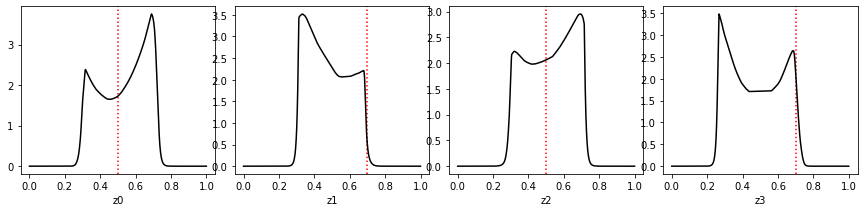

In [8]:
swyft.plot1d(re, x0 = x0, z0 = z0, cmap = 'Greys', dims = (15, 3))

In [9]:
re2 = swyft.RatioEstimation(zdim, td, device = DEVICE, combinations = comb2d)

In [10]:
re2.train(max_epochs = MAX_EPOCHS, nbatch = 16, lr_schedule = [1e-3, 3e-4, 1e-4])

Start training
LR iteration 0
Total epochs: 4
Validation losses: [14.3587067425251, 14.002743482589722, 13.73943343758583, 13.759873241186142]
LR iteration 1
Total epochs: 6
Validation losses: [13.617747008800507, 13.481643617153168, 13.42318919301033, 13.396035999059677, 13.370573937892914, 13.401275277137756]
LR iteration 2
Total epochs: 3
Validation losses: [13.467840760946274, 13.32133463025093, 13.367472887039185]


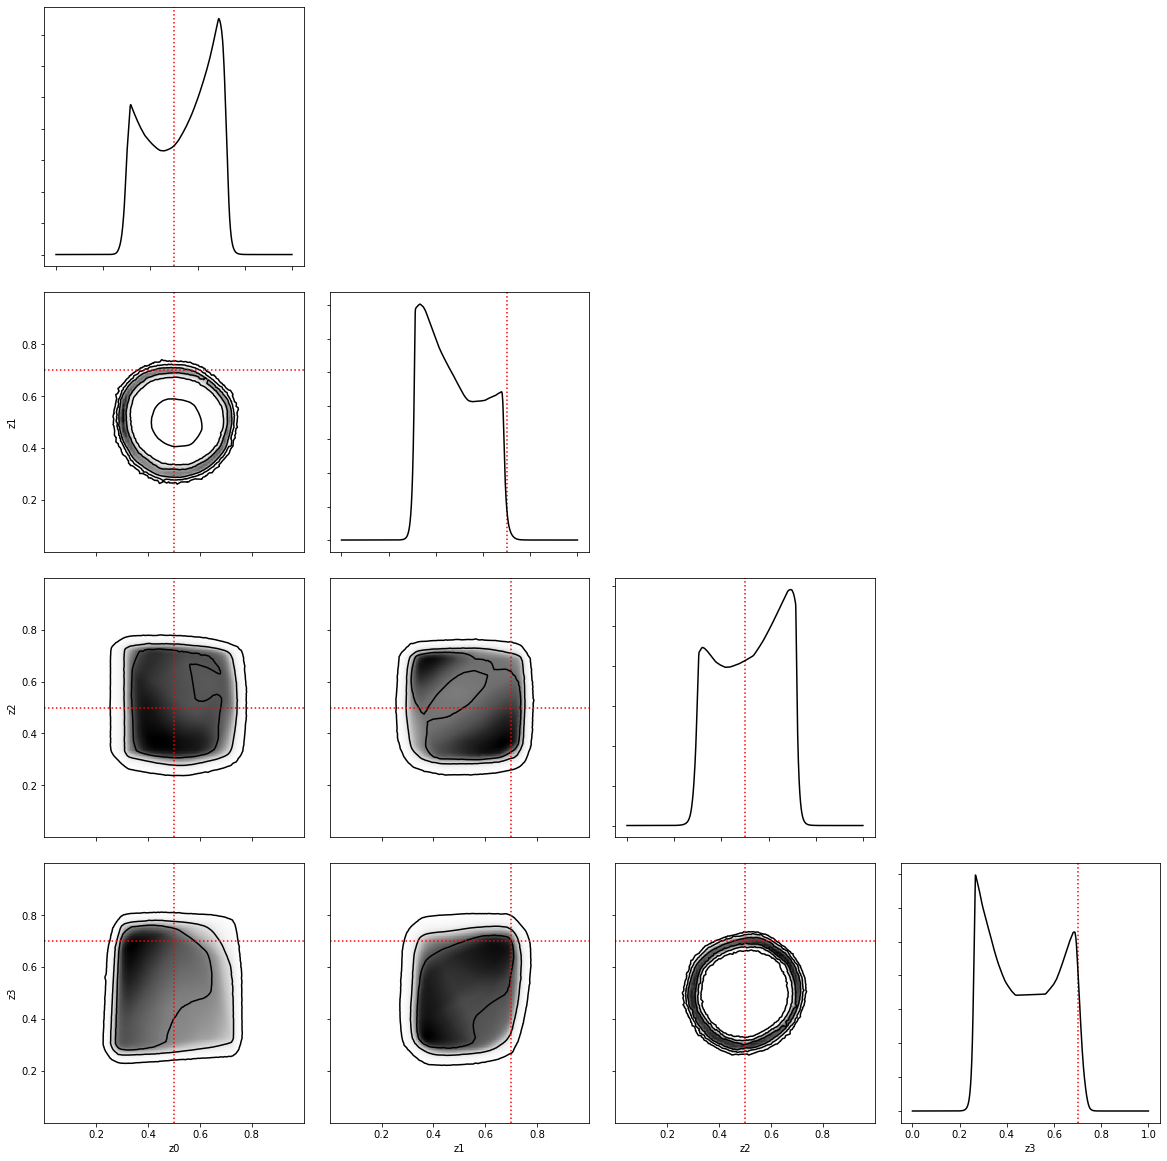

In [11]:
swyft.corner(re, re2, x0 = x0, z0 = z0, cmap = 'Greys', dim = 20)